For this project you will use `requests` package and the SODA API to access data through https://data.nashville.gov/. We'll start out with something familiar, the [Top 500 Monthly Searches](https://data.nashville.gov/Public-Services/Nashville-gov-Top-500-Monthly-Searches/fuaa-r5cm), then pull in different datasets further on. You will make different API requests for each individual question.

The documentation for the SODA API is [here](https://dev.socrata.com/consumers/getting-started.html). 

In [1]:
import requests
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
endpoint = 'https://data.nashville.gov/resource/fuaa-r5cm.json'

#### Question 1
Make an API request that returns the months where "fire" was searched in 2016. Which month had the most searches? 

In [3]:
params = {
    'year' : 2016,
    'query_text' : 'fire'
}

In [4]:
response = requests.get(endpoint, params = params)
response

<Response [200]>

In [5]:
res = response.json()
res

[{'month_name': 'January',
  'year': '2016',
  'query_count': '19',
  'query_text': 'fire'},
 {'month_name': 'February',
  'year': '2016',
  'query_count': '35',
  'query_text': 'fire'},
 {'month_name': 'March',
  'year': '2016',
  'query_count': '32',
  'query_text': 'fire'},
 {'month_name': 'April',
  'year': '2016',
  'query_count': '26',
  'query_text': 'fire'},
 {'month_name': 'May',
  'year': '2016',
  'query_count': '24',
  'query_text': 'fire'},
 {'month_name': 'June',
  'year': '2016',
  'query_count': '31',
  'query_text': 'fire'},
 {'month_name': 'July',
  'year': '2016',
  'query_count': '24',
  'query_text': 'fire'},
 {'month_name': 'August',
  'year': '2016',
  'query_count': '47',
  'query_text': 'fire'},
 {'month_name': 'September',
  'year': '2016',
  'query_count': '36',
  'query_text': 'fire'},
 {'month_name': 'October',
  'year': '2016',
  'query_count': '38',
  'query_text': 'fire'},
 {'month_name': 'November',
  'year': '2016',
  'query_count': '32',
  'query_text

In [6]:
res_df = pd.DataFrame(res)
res_df 

,month_name,year,query_count,query_text
0,January,2016,19,fire
1,February,2016,35,fire
2,March,2016,32,fire
3,April,2016,26,fire
4,May,2016,24,fire
5,June,2016,31,fire
6,July,2016,24,fire
7,August,2016,47,fire
8,September,2016,36,fire
9,October,2016,38,fire


In [7]:
max_month = res_df.max()
max_month

month_name     September
year                2016
query_count           47
query_text          fire
dtype: object

Fire was searched 47 times in September, 2016 (the most times for that year)

#### Question 2 
Make an API request that returns all the times a query was run more than 100 times in a month. How many times did this occur? 

In [8]:
res1 = requests.get('https://data.nashville.gov/resource/fuaa-r5cm.json?$where=query_count > 100').json()

In [9]:
len(res1)

1000

In [10]:
params1 = {
    '$where' : 'query_count > 100' 
}

response1 = requests.get(endpoint , params=params1)
response1

<Response [200]>

In [11]:
len(response1.json())

1000

There are 1000 instances when a query term was search more than 100 times in a given month

#### Question 3
Make another API request that returns all the times "codes" was searched more than 100 times in a month. How many times did this occur? 

In [12]:
params2 = {
    'query_text' : 'codes',
    '$where' : 'query_count > 100'
}

response2 = requests.get(endpoint, params=params2)
response2

<Response [200]>

In [13]:
len(response2.json())

56

There are 56 instances when the term 'codes' was searched more than 100 times in a given month

#### Question 4
Make an API request that returns the entire Top 500 Monthly Searches dataset. Make a chart that shows the number of times "maps" was searched in a month across the entire time frame.

In [14]:
params3 = {
    '$limit' : 43677
}
response3 = requests.get(endpoint, params=params3)
response3

<Response [200]>

In [15]:
full_res = response3.json()
full_res

[{'month_name': 'January',
  'year': '2014',
  'query_count': '223',
  'query_text': 'ebid'},
 {'month_name': 'January',
  'year': '2014',
  'query_count': '112',
  'query_text': 'property maps'},
 {'month_name': 'January',
  'year': '2014',
  'query_count': '97',
  'query_text': 'maps'},
 {'month_name': 'January',
  'year': '2014',
  'query_count': '90',
  'query_text': 'property tax'},
 {'month_name': 'January',
  'year': '2014',
  'query_count': '76',
  'query_text': 'jobs'},
 {'month_name': 'January',
  'year': '2014',
  'query_count': '75',
  'query_text': 'employment'},
 {'month_name': 'January',
  'year': '2014',
  'query_count': '73',
  'query_text': 'human resources'},
 {'month_name': 'January',
  'year': '2014',
  'query_count': '62',
  'query_text': 'police'},
 {'month_name': 'January',
  'year': '2014',
  'query_count': '61',
  'query_text': 'criminal court clerk'},
 {'month_name': 'January',
  'year': '2014',
  'query_count': '53',
  'query_text': 'media releases'},
 {'mon

In [16]:
maps_dict = {}

for line in full_res:
    text = line.get('query_text')
    mon_yr = str(line.get('month_name')+', '+line.get('year'))
    count = line.get('query_count')
    if text == 'maps':
       maps_dict[mon_yr] = count

In [53]:
maps_df = pd.DataFrame.from_dict(maps_dict, orient='index')
maps_df = maps_df.reset_index()
maps_df.columns = ['month', 'count']
maps_df['count'] = maps_df['count'].astype(float)
maps_df['month'] = pd.to_datetime(maps_df['month'])
maps_df['mon_yr'] = maps_df['month'].dt.strftime('%m/%Y')
maps_df = maps_df.sort_values('month')
maps_df

,month,count,mon_yr
0,2014-01-01,97.0,01/2014
1,2014-02-01,140.0,02/2014
2,2014-03-01,144.0,03/2014
3,2014-04-01,152.0,04/2014
4,2014-05-01,119.0,05/2014
...,...,...,...
77,2020-11-01,86.0,11/2020
78,2020-12-01,113.0,12/2020
79,2021-03-01,132.0,03/2021
80,2021-04-01,148.0,04/2021


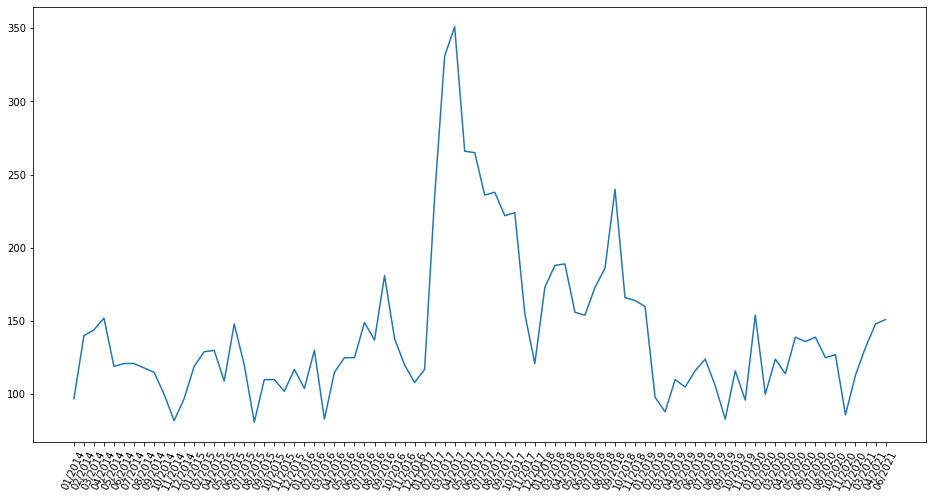

In [54]:
plt.figure(figsize=(16, 8))
plt.plot('mon_yr', 'count', data = maps_df)
plt.xticks(rotation = 65);

### Stretch Questions

#### Question 5
Make an API request to pull back all the data from [hubNashville (311) Service Requests](https://data.nashville.gov/Public-Services/hubNashville-311-Service-Requests/7qhx-rexh) (check to see how many rows you can return in a single request). Compare it to the Top 500 Monthly Searches data set. What do you observe? (This is open-ended, there isn't a specific answer for this one)

In [19]:
hub_endpoint = 'https://data.nashville.gov/resource/7qhx-rexh.json'
hub_params = {
    '$limit' : 984962
}
hub_response = requests.get(hub_endpoint, params=hub_params)
hub_response

<Response [200]>

In [20]:
hub_res = hub_response.json()
hub_res

[{'case_number': '170144',
  'status': 'Closed',
  'case_request': 'Streets, Roads & Sidewalks',
  'case_subrequest': 'Overgrowth on right of way',
  'additional_subrequest': 'Roadway',
  'date_time_opened': '2019-04-16T15:54:00.000',
  'date_time_closed': '2019-04-18T16:06:00.000',
  'case_origin': 'Phone',
  'state_issue': 'FALSE',
  'closed_when_created': 'FALSE',
  'incident_address': 'Hailey Ave',
  'incident_city': 'NASHVILLE',
  'incident_council_district': '2',
  'incident_zip_code': '37218',
  'latitude': '36.1903195',
  'longitude': '-86.8317307',
  'mapped_location': {'latitude': '36.1903195', 'longitude': '-86.8317307'},
  ':@computed_region_wvby_4s8j': '1',
  ':@computed_region_3aw5_2wv7': '1',
  ':@computed_region_p6sk_2acq': '2',
  ':@computed_region_gxvr_9jxz': '34',
  ':@computed_region_yf9r_ed6g': '2',
  ':@computed_region_fvtq_wnma': '23',
  ':@computed_region_s8bq_67w7': '2',
  ':@computed_region_v67z_xm3t': '1',
  ':@computed_region_kh5x_g7w5': '2',
  ':@computed_r

In [21]:
hub_df = pd.DataFrame(hub_res)
hub_df

,case_number,status,case_request,case_subrequest,additional_subrequest,date_time_opened,date_time_closed,case_origin,state_issue,closed_when_created,...,:@computed_region_v67z_xm3t,:@computed_region_kh5x_g7w5,:@computed_region_cfa7_hbpz,:@computed_region_sjpq_96s8,:@computed_region_gisn_y5cm,:@computed_region_b9k3_hpc2,contact_type,parent_case,oem_id,preferred_language
0,170144,Closed,"Streets, Roads & Sidewalks",Overgrowth on right of way,Roadway,2019-04-16T15:54:00.000,2019-04-18T16:06:00.000,Phone,FALSE,FALSE,...,1,2,67,16168,6,1,NaN,NaN,NaN,NaN
1,161502,Closed,"Trash, Recycling & Litter",Missed Pickup - Recycle Cart Service,Recycle - Curbside/Alley Missed Pickup,2019-03-29T14:27:00.000,2019-04-03T21:29:00.000,hubNashville Community,FALSE,FALSE,...,6,12,628,15804,5,6,NaN,NaN,NaN,NaN
2,169037,Closed,Resolved by hubNashville on First Call,Resolved by hubNashville on First Call,Resolved by hubNashville on First Call,2019-04-12T21:08:00.000,2019-04-12T21:08:00.000,Phone,FALSE,TRUE,...,5,14,2,15798,8,5,NaN,NaN,NaN,NaN
3,169463,Closed,Resolved by hubNashville on First Call,Resolved by hubNashville on First Call,Resolved by hubNashville on First Call,2019-04-15T15:26:00.000,2019-04-15T15:26:00.000,Phone,FALSE,TRUE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,160904,Closed,"Streets, Roads & Sidewalks",Request New Sign,Request New Sign,2019-03-28T15:30:00.000,2019-06-26T16:22:00.000,Phone,FALSE,FALSE,...,9,27,NaN,16166,3,9,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
984957,158033,Closed,"Streets, Roads & Sidewalks",Remove debris in roadway,Remove debris in roadway,2019-03-22T13:00:00.000,2019-03-22T13:23:00.000,Phone,FALSE,FALSE,...,4,16,NaN,28805,3,4,NaN,NaN,OE-00008990_3/21/2019 13:20,NaN
984958,157812,Closed,"Trash, Recycling & Litter",Missed Pickup - Recycle Cart Service,Recycle - Curbside/Alley Missed Pickup,2019-03-21T18:48:00.000,2019-03-29T21:26:00.000,hubNashville Community,FALSE,FALSE,...,1,14,642,15798,8,1,Resident,NaN,NaN,NaN
984959,161133,Closed,"Trash, Recycling & Litter",Missed Pickup - Recycle Cart Service,Recycle - Curbside/Alley Missed Pickup,2019-03-28T19:11:00.000,2019-04-02T21:32:00.000,Phone,FALSE,FALSE,...,3,29,323,24062,7,3,NaN,NaN,NaN,NaN
984960,166973,Closed,"Trash, Recycling & Litter",Missed Pickup - Trash Cart Service,Trash - Curbside/Alley Missed Pickup,2019-04-10T12:04:00.000,2019-04-12T20:40:00.000,Phone,FALSE,FALSE,...,2,3,NaN,15550,2,2,NaN,NaN,NaN,NaN


In [22]:
hub_df[['date_time_opened', 'date_time_closed']] = hub_df[['date_time_opened', 'date_time_closed']].apply(pd.to_datetime)
hub_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 984962 entries, 0 to 984961
Data columns (total 34 columns):
 #   Column                       Non-Null Count   Dtype         
---  ------                       --------------   -----         
 0   case_number                  984962 non-null  object        
 1   status                       984962 non-null  object        
 2   case_request                 984541 non-null  object        
 3   case_subrequest              980324 non-null  object        
 4   additional_subrequest        946848 non-null  object        
 5   date_time_opened             984962 non-null  datetime64[ns]
 6   date_time_closed             966261 non-null  datetime64[ns]
 7   case_origin                  984962 non-null  object        
 8   state_issue                  984962 non-null  object        
 9   closed_when_created          984962 non-null  object        
 10  incident_address             672680 non-null  object        
 11  incident_city             

In [23]:
hub_df['open_mon_yr'] = hub_df['date_time_opened'].dt.to_period('M')
hub_df['close_mon_yr'] = hub_df['date_time_closed'].dt.to_period('M')
simp_hub_df = hub_df[['case_number', 'status', 'case_request', 'case_subrequest', 'additional_subrequest', 
                      'open_mon_yr', 'close_mon_yr']]
simp_hub_df = simp_hub_df.sort_values('open_mon_yr')
simp_hub_df

,case_number,status,case_request,case_subrequest,additional_subrequest,open_mon_yr,close_mon_yr
160914,2214,Closed,"Trash, Recycling & Litter",Cart Service,Trash - Report a Damaged Cart,2017-07,2017-08
162047,1904,Closed,"Streets, Roads & Sidewalks",Blocking the Right of Way,Blocking the Right of Way,2017-07,2017-07
162046,3088,Closed,"Trash, Recycling & Litter",File a Trash or Recycling Complaint,Trash Collection Complaint,2017-07,2017-08
162045,2474,Closed,"Trash, Recycling & Litter",Cart Service,Recycling - Report a Damaged Cart,2017-07,2017-07
162044,2252,Closed,"Streets, Roads & Sidewalks",Traffic Light Issue,Traffic Light Issue,2017-07,2017-07
...,...,...,...,...,...,...,...
224257,1014081,Closed,Resolved by hubNashville on First Call,Resolved by hubNashville on First Call,Resolved by hubNashville on First Call,2022-07,2022-07
301414,1010861,Closed,"Streets, Roads & Sidewalks",PWRD,NaN,2022-07,2022-07
224258,1014160,Closed,Public Safety,Repossessed Vehicle,Repossessed Vehicle,2022-07,2022-07
301416,1010866,Closed,Public Safety,Request Non-Emergency Police Assistance,NaN,2022-07,2022-07


In [24]:
search_df = pd.DataFrame(full_res)
search_df['mon_yr'] = search_df['month_name']+' '+search_df['year']
search_df['mon_yr'] = pd.to_datetime(search_df['mon_yr'])
search_df['mon_yr'] = search_df['mon_yr'].dt.to_period('M')
search_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43677 entries, 0 to 43676
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype    
---  ------       --------------  -----    
 0   month_name   43677 non-null  object   
 1   year         43677 non-null  object   
 2   query_count  43676 non-null  object   
 3   query_text   43677 non-null  object   
 4   month        15177 non-null  object   
 5   mon_yr       43677 non-null  period[M]
dtypes: object(5), period[M](1)
memory usage: 2.0+ MB


In [25]:
simp_search_df = search_df[['query_text', 'mon_yr', 'query_count']]
simp_search_df['query_text'] = search_df['query_text'].str.strip(' " \'()-').str.lower()
simp_search_df

C:\Users\mews2\AppData\Local\Temp\ipykernel_3128\1514520562.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  simp_search_df['query_text'] = search_df['query_text'].str.strip(' " \'()-').str.lower()


,query_text,mon_yr,query_count
0,ebid,2014-01,223
1,property maps,2014-01,112
2,maps,2014-01,97
3,property tax,2014-01,90
4,jobs,2014-01,76
...,...,...,...
43672,sign ordinance,2021-07,8
43673,snap,2021-07,8
43674,small business,2021-07,8
43675,water department,2021-07,8


In [26]:
searches = simp_search_df.groupby(['query_text', 'mon_yr'])['query_count'].sum()
searches = pd.DataFrame(searches).reset_index()
searches['query_count'] = searches['query_count'].astype(float)
searches

,query_text,mon_yr,query_count
0,,2020-11,10.0
1,$500,2015-04,13.0
2,"0""xor(if(now()=sysdate(),sleep(15),0))xor""z",2021-03,10.0
3,"0'xor(if(now()=sysdate(),sleep(15),0))xor'z",2021-03,10.0
4,01 civil service minutes,2016-11,7.0
...,...,...,...
39678,zumba,2017-01,7.0
39679,“jonathan sharp”,2021-05,7.0
39680,” joe davis martin” ”1995” ”warfield”,2020-06,15.0
39681,�''�,2020-08,10.0


In [27]:
hub_requests = simp_hub_df.groupby(['case_request', 'open_mon_yr'])['status'].count()
hub_requests = pd.DataFrame(hub_requests).reset_index()
hub_requests = hub_requests.rename(columns = { 'case_request' : 'request_type',
                                              'status' : 'request_count'})
hub_requests

,request_type,open_mon_yr,request_count
0,2nd Avenue Explosion Information and Assistance,2020-12,177
1,2nd Avenue Explosion Information and Assistance,2021-01,39
2,2nd Avenue Explosion Information and Assistance,2021-02,1
3,2nd Avenue Explosion Information and Assistance,2021-03,3
4,2nd Avenue Explosion Information and Assistance,2021-09,3
...,...,...,...
786,Workforce & Jobs,2017-12,2
787,Workforce & Jobs,2018-01,1
788,Workforce & Jobs,2018-03,1
789,Workforce & Jobs,2018-08,1


In [28]:
early_covid_searches = searches.loc[(searches['mon_yr'] >= '03/2020') &(searches['mon_yr'] <= '05-2020')]
early_covid_searches = early_covid_searches.sort_values('query_count', ascending=False)
early_covid_searches.head(50)

,query_text,mon_yr,query_count
27162,payroll,2020-03,318.0
27163,payroll,2020-04,279.0
10178,curfew,2020-05,219.0
7702,codes,2020-05,184.0
7701,codes,2020-04,183.0
27164,payroll,2020-05,183.0
14048,ess,2020-03,166.0
7700,codes,2020-03,164.0
21196,maps,2020-05,139.0
28706,police report,2020-05,137.0


In [29]:
pre_searches = searches.loc[(searches['mon_yr'] >= '03/2019') &(searches['mon_yr'] <= '05-2019')]
pre_searches = pre_searches.sort_values('query_count', ascending=False)
pre_searches.head(50)

,query_text,mon_yr,query_count
19716,jobs,2019-05,176.0
7690,codes,2019-05,174.0
17811,human resources,2019-03,174.0
27152,payroll,2019-05,169.0
7689,codes,2019-04,168.0
17813,human resources,2019-05,162.0
261,2019-0163437,2019-03,155.0
17812,human resources,2019-04,153.0
14038,ess,2019-05,147.0
19714,jobs,2019-03,141.0


In [30]:
early_covid_requests = hub_requests.loc[(hub_requests['open_mon_yr'] >= '03/2020') & 
                                  (hub_requests['open_mon_yr'] <= '05-2020')]
early_covid_requests = early_covid_requests.sort_values('request_count', ascending=False)
early_covid_requests.head(50)

,request_type,open_mon_yr,request_count
550,Resolved by hubNashville on First Call,2020-05,8183
549,Resolved by hubNashville on First Call,2020-04,6296
744,"Trash, Recycling & Litter",2020-05,6276
548,Resolved by hubNashville on First Call,2020-03,5920
742,"Trash, Recycling & Litter",2020-03,5318
743,"Trash, Recycling & Litter",2020-04,4838
6,COVID-19,2020-04,3609
620,"Streets, Roads & Sidewalks",2020-05,3258
122,Hands On Volunteers,2020-03,2637
7,COVID-19,2020-05,2014


In [31]:
all_covid_req = simp_hub_df.loc[simp_hub_df['case_request'] == 'COVID-19']
all_covid_req

,case_number,status,case_request,case_subrequest,additional_subrequest,open_mon_yr,close_mon_yr
826087,330954,Closed,COVID-19,COVID-19 Questions,COVID-19 Questions,2020-03,2020-03
836594,330783,Closed,COVID-19,COVID-19 Questions,COVID-19 Questions,2020-03,2020-03
836611,330808,Closed,COVID-19,COVID-19 Questions,COVID-19 Questions,2020-03,2020-03
826142,334789,Closed,COVID-19,COVID-19 Questions,COVID-19 Questions,2020-03,2020-04
826143,330970,Closed,COVID-19,COVID-19 Questions,COVID-19 Questions,2020-03,2020-03
...,...,...,...,...,...,...,...
257740,952405,Closed,COVID-19,COVID-19 Questions,COVID-19 Questions,2022-04,2022-04
244220,971086,New,COVID-19,COVID-19 Questions,COVID-19 Questions,2022-05,NaT
289164,994490,New,COVID-19,COVID-19 Questions,COVID-19 Questions,2022-06,NaT
276416,998138,New,COVID-19,COVID-19 Questions,COVID-19 Questions,2022-06,NaT


In [32]:
monthly_covid_req = all_covid_req.groupby(['open_mon_yr'])['case_number'].count()
monthly_covid_req = pd.DataFrame(monthly_covid_req).reset_index()
monthly_covid_req.columns = ['open_yr_month', 'case_count']
monthly_covid_req['yr_mon'] = monthly_covid_req['open_yr_month'].astype(str)
monthly_covid_req

,open_yr_month,case_count,yr_mon
0,2020-03,786,2020-03
1,2020-04,3609,2020-04
2,2020-05,2014,2020-05
3,2020-06,2092,2020-06
4,2020-07,3313,2020-07
5,2020-08,1891,2020-08
6,2020-09,912,2020-09
7,2020-10,1151,2020-10
8,2020-11,1261,2020-11
9,2020-12,1165,2020-12


In [33]:
covid_searches = searches.loc[(searches['query_text'].str.contains('covid')) | 
                              (searches['query_text'].str.contains('corona'))]
covid_searches.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 189 entries, 541 to 37477
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype    
---  ------       --------------  -----    
 0   query_text   189 non-null    object   
 1   mon_yr       189 non-null    period[M]
 2   query_count  189 non-null    float64  
dtypes: float64(1), object(1), period[M](1)
memory usage: 5.9+ KB


In [34]:
monthly_covid_searches = covid_searches.groupby(['mon_yr'])['query_count'].sum()
monthly_covid_searches = pd.DataFrame(monthly_covid_searches).reset_index()
monthly_covid_searches['yr_mon'] = monthly_covid_searches['mon_yr'].astype(str)
monthly_covid_searches

,mon_yr,query_count,yr_mon
0,2020-02,24.0,2020-02
1,2020-03,283.0,2020-03
2,2020-04,228.0,2020-04
3,2020-05,257.0,2020-05
4,2020-06,336.0,2020-06
5,2020-07,339.0,2020-07
6,2020-08,194.0,2020-08
7,2020-09,159.0,2020-09
8,2020-10,121.0,2020-10
9,2020-11,297.0,2020-11


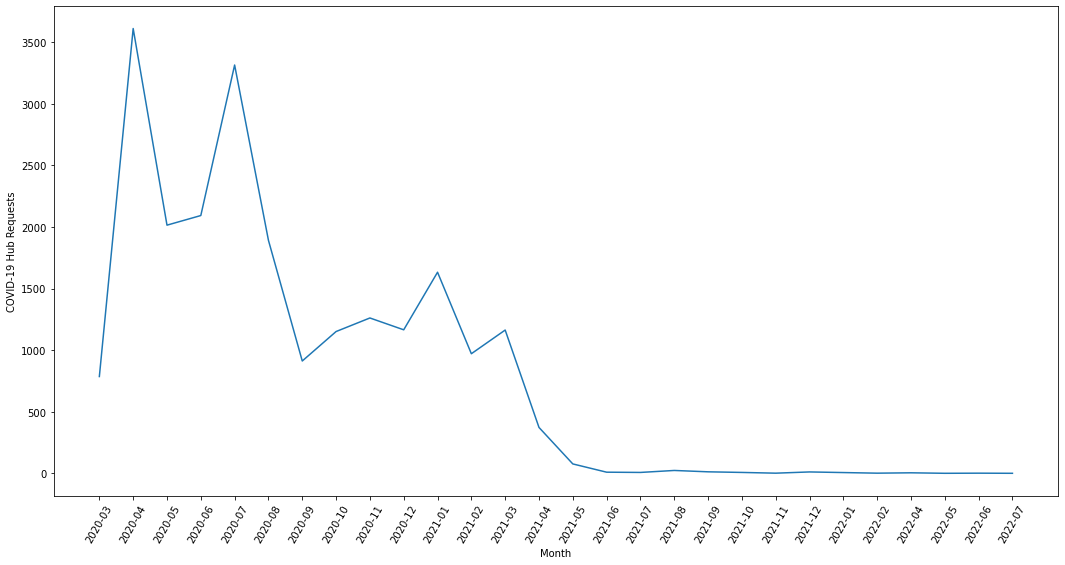

In [35]:
plt.figure(figsize = (18,9))
plt.plot('yr_mon', 'case_count', data = monthly_covid_req)
plt.xlabel('Month')
plt.ylabel('COVID-19 Hub Requests')
plt.xticks(rotation = 60);

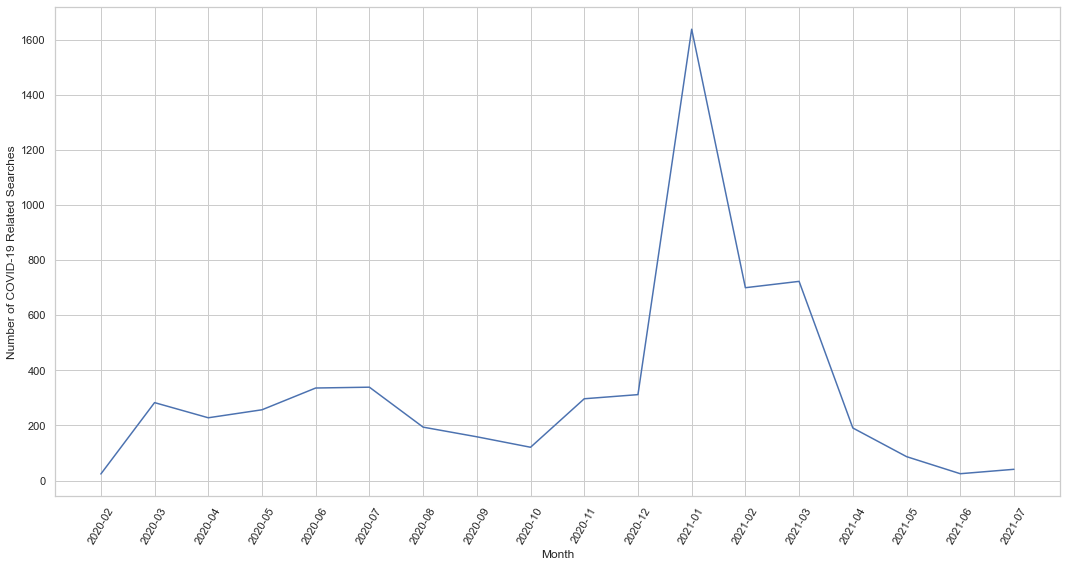

In [163]:
plt.figure(figsize = (18,9))
plt.plot('yr_mon', 'query_count', data = monthly_covid_searches)
plt.xlabel('Month')
plt.ylabel('Number of COVID-19 Related Searches')
#plt.ylim(0, 3600)
plt.xticks(rotation = 60);

#### Question 6
Find 2 new data sets on data.nashville.gov, make API requests to pull the data, and do an analysis that combines the data sets. 

In [37]:
str_endpoint = 'https://data.nashville.gov/resource/2z82-v8pm.json'
str_params = {
    '$limit' : 13085
}

str_response = requests.get(str_endpoint, params= str_params)
str_response

<Response [200]>

In [38]:
str_res = str_response.json()
str_permits = pd.DataFrame(str_res)
str_permits

,permit,applicant,contact,permit_subtype_description,permit_status,parcel,date_entered,date_issued,expiration_date,address,...,:@computed_region_wvby_4s8j,:@computed_region_3aw5_2wv7,:@computed_region_cfa7_hbpz,:@computed_region_sjpq_96s8,:@computed_region_f73m_vb2k,:@computed_region_c9xn_skx3,:@computed_region_gisn_y5cm,:@computed_region_v3ji_vzam,permit_owner_addr1,permit_owner_addr3
0,201622784,"Market Street Emporium, Llc",Market Street,Short Term Rental � Multifamily,EXPIRED,09306208400,2016-05-16T00:00:00.000,2016-06-16T00:00:00.000,2022-06-16T00:00:00.000,112 2ND AVE N 102,...,1,1,50,30396,7,13,1,2005,NaN,NaN
1,201622787,"Market Street Emporium, Llc",Market Street,Short Term Rental � Multifamily,EXPIRED,09306208400,2016-05-16T00:00:00.000,2016-06-16T00:00:00.000,2022-06-16T00:00:00.000,112 2ND AVE N 104,...,1,1,50,30396,7,13,1,2005,NaN,NaN
2,2021045146,"C&S MANAGMENT, LLC","C&S MANAGMENT, LLC",Short Term Rental � Multifamily,ISSUED,081034A01300CO,2021-07-16T00:00:00.000,2021-07-23T00:00:00.000,2023-07-23T00:00:00.000,2132 9TH AVE N,...,1,1,NaN,NaN,1,2,6,2005,Doug Bowman,NaN
3,2022043884,"JEFFERSON, ALLISON & MATTHEW","JEFFERSON, ALLISON & MATTHEW",Short Term Rental - Owner Occupied,ISSUED,06108005600,2022-06-30T00:00:00.000,2022-06-30T00:00:00.000,2023-06-30T00:00:00.000,4211 BRUSH HILL RD,...,1,1,82,16164,2,8,2,2005,NaN,NaN
4,2019011281,Megan Wicks,Megan Wicks,Short Term Rental - Owner Occupied,CANCELLED,11801031400,2019-02-26T00:00:00.000,2019-03-07T00:00:00.000,2023-03-07T00:00:00.000,919B MONTROSE AVE,...,1,1,623,30813,9,11,5,2005,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13080,2021048807,"HEITHCOCK, AUSTIN","HEITHCOCK, AUSTIN",Short Term Rental - Owner Occupied,ISSUED,082120W00500CO,2021-08-02T00:00:00.000,2021-08-09T00:00:00.000,2023-08-09T00:00:00.000,106 N 8TH ST 1,...,1,1,68,15548,7,6,2,2005,NaN,NaN
13081,2019022082,Michael & Heather Hoover,Michael & Heather Hoover,Short Term Rental - Owner Occupied,EXPIRED,08301030400,2019-04-16T00:00:00.000,2019-05-30T00:00:00.000,2022-06-29T00:00:00.000,1307B GREENWOOD AVE,...,1,1,13,15548,7,7,2,2005,NaN,NaN
13082,2021027824,"ROBINSON, QUINTIN",Quintin Robinson,Short Term Rental - Owner Occupied,ISSUED,09316006200,2021-05-04T00:00:00.000,2021-08-05T00:00:00.000,2022-08-05T00:00:00.000,107 CLAIBORNE ST,...,1,1,49,15800,7,13,3,2005,NaN,NaN
13083,2021037141,"1606 MUSIC ROW, LLC",Kurt Crowley,Short Term Rental � Multifamily,EXPIRED,104080Q00100CO,2021-06-14T00:00:00.000,2021-06-29T00:00:00.000,2022-06-29T00:00:00.000,1606A 16TH AVE S,...,1,1,NaN,15804,7,11,5,2005,Rod Roudi,NaN


In [39]:
prop_endpoint = 'https://data.nashville.gov/resource/479w-kw2x.json'
prop_params = {
    '$limit' : 100000
}

prop_response = requests.get(prop_endpoint, params=prop_params)
prop_response

<Response [200]>

In [40]:
prop_res = prop_response.json()
prop_violations = pd.DataFrame(prop_res)
prop_violations

,request,date_received,property_apn,property_address,city,state,zip,property_owner,complaint_source,reported_problem,...,:@computed_region_sjpq_96s8,:@computed_region_v3ji_vzam,:@computed_region_c9xn_skx3,:@computed_region_f73m_vb2k,:@computed_region_kh5x_g7w5,:@computed_region_yf9r_ed6g,:@computed_region_fvtq_wnma,:@computed_region_b9k3_hpc2,:@computed_region_cfa7_hbpz,violations_noted
0,22-1292095,2022-03-25T00:00:00.000,07500020000,5005 OLD HICKORY BLVD,HERMITAGE,TN,37076,FCPT HOLDINGS LLC,INSPECTOR REPORTED,sign removal,...,28805,2005,19,4,19,19,6,4,NaN,NaN
1,21-1281755,2021-11-29T00:00:00.000,NaN,NaN,NaN,NaN,NaN,OWNER INFO UNAVAILABLE,EMAIL,Grafitti on building,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,21-1284275,2021-12-30T00:00:00.000,14712010300,4647 NOLENSVILLE PIKE,NASHVILLE,TN,37211,"I & M, LLC",INSPECTOR REPORTED,sign removal,...,15803,2005,25,3,25,25,46,3,NaN,NaN
3,21-1278621,2021-10-21T00:00:00.000,149010B10300CO,209 ALDWYCH WAY,ANTIOCH,TN,37013,"CASTILLO, MACARENA",HUB,Type: Public Safety - Abandoned Vehicles\n\nDe...,...,24062,2005,26,8,26,26,2,8,275,NaN
4,21-1264593,2021-05-21T00:00:00.000,14900020400,2416 UNA ANTIOCH PIKE,ANTIOCH,TN,37013,"ANDERT, FIDENCIO & ALVARADO, IRMA SUSANA",INSPECTOR REPORTED,REMOVED,...,24062,2005,26,8,26,26,2,8,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95639,20-1228359,2020-05-18T00:00:00.000,092070I11100CO,612 21ST AVE N 111,NASHVILLE,TN,37203,"SEELEY, MEREDITH",INSPECTOR REPORTED,permit number not displayed,...,30406,2005,15,7,15,15,25,7,NaN,PERMIT NOT DISPLAYED
95640,20-1246762,2020-11-13T00:00:00.000,09016011000,542 WESTBORO DR,NASHVILLE,TN,37209,"CONNELL, SPENCER",INSPECTOR REPORTED,parking on grass,...,15798,2005,14,5,14,14,12,5,2,PARKING ON GRASS
95641,21-1257852,2021-03-19T00:00:00.000,07412014800,5014 BONNAMEADE DR,HERMITAGE,TN,37076,"FORD, TAKESHA S.",INSPECTOR REPORTED,PARKING ON GRASS,...,28805,2005,19,4,19,19,6,4,118,PARKING ON GRASS
95642,20-1245856,2020-11-04T00:00:00.000,11902004300,204 GARWOOD DR,NASHVILLE,TN,37210,"SMITH, ERIC M. & ISIL Y. & LEIMBACH, MICHAEL",HUB,Type: Property Violations - Cars Parked On Law...,...,15800,2005,21,9,21,21,5,9,1161,"OPEN STORAGE, JUNK, TRASH, DEBRIS"


In [41]:
prop_violations = prop_violations.drop(columns = ['council_district', ':@computed_region_wvby_4s8j', 
                                                  ':@computed_region_3aw5_2wv7', 
                                                  ':@computed_region_p6sk_2acq', 
                                                  ':@computed_region_gxvr_9jxz', 
                                                  ':@computed_region_gisn_y5cm', 
                                                  ':@computed_region_sjpq_96s8', 
                                                  ':@computed_region_v3ji_vzam', 
                                                  ':@computed_region_c9xn_skx3', 
                                                  ':@computed_region_f73m_vb2k', 
                                                  ':@computed_region_kh5x_g7w5', 
                                                  ':@computed_region_yf9r_ed6g', 
                                                  ':@computed_region_fvtq_wnma', 
                                                  ':@computed_region_b9k3_hpc2', 
                                                  ':@computed_region_cfa7_hbpz' ])
prop_violations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95644 entries, 0 to 95643
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   request               95644 non-null  object
 1   date_received         95644 non-null  object
 2   property_apn          95338 non-null  object
 3   property_address      95338 non-null  object
 4   city                  95337 non-null  object
 5   state                 95338 non-null  object
 6   zip                   95337 non-null  object
 7   property_owner        95644 non-null  object
 8   complaint_source      95643 non-null  object
 9   reported_problem      94470 non-null  object
 10  status                95644 non-null  object
 11  last_activity_date    95120 non-null  object
 12  last_activity         95120 non-null  object
 13  last_activity_result  95120 non-null  object
 14  mapped_location       95338 non-null  object
 15  violations_noted      41442 non-null

In [42]:
prop_violations = prop_violations.rename(columns = {'property_address' : 'address'})

In [43]:
str_permits = str_permits.drop(columns = ['parcel', 'census_tract', 
                                          ':@computed_region_p6sk_2acq', 
                                          ':@computed_region_gxvr_9jxz', 
                                          ':@computed_region_wvby_4s8j', 
                                          ':@computed_region_3aw5_2wv7', 
                                          ':@computed_region_cfa7_hbpz', 
                                          ':@computed_region_sjpq_96s8', 
                                          ':@computed_region_f73m_vb2k', 
                                          ':@computed_region_c9xn_skx3', 
                                          ':@computed_region_gisn_y5cm', 
                                          ':@computed_region_v3ji_vzam'])
str_permits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13085 entries, 0 to 13084
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   permit                      13085 non-null  object
 1   applicant                   13080 non-null  object
 2   contact                     12697 non-null  object
 3   permit_subtype_description  13085 non-null  object
 4   permit_status               13085 non-null  object
 5   date_entered                13085 non-null  object
 6   date_issued                 11800 non-null  object
 7   expiration_date             13081 non-null  object
 8   address                     13085 non-null  object
 9   city                        13084 non-null  object
 10  state                       13084 non-null  object
 11  zip                         13085 non-null  object
 12  subdivision_lot             13083 non-null  object
 13  purpose                     12998 non-null  ob

In [44]:
str_pv = str_permits.merge(prop_violations, how='left', on=['address', 'city', 'state', 'zip'])
str_pv

,permit,applicant,contact,permit_subtype_description,permit_status,date_entered,date_issued,expiration_date,address,city,...,property_apn,property_owner,complaint_source,reported_problem,status,last_activity_date,last_activity,last_activity_result,mapped_location_y,violations_noted
0,201622784,"Market Street Emporium, Llc",Market Street,Short Term Rental � Multifamily,EXPIRED,2016-05-16T00:00:00.000,2016-06-16T00:00:00.000,2022-06-16T00:00:00.000,112 2ND AVE N 102,NASHVILLE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,201622787,"Market Street Emporium, Llc",Market Street,Short Term Rental � Multifamily,EXPIRED,2016-05-16T00:00:00.000,2016-06-16T00:00:00.000,2022-06-16T00:00:00.000,112 2ND AVE N 104,NASHVILLE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2021045146,"C&S MANAGMENT, LLC","C&S MANAGMENT, LLC",Short Term Rental � Multifamily,ISSUED,2021-07-16T00:00:00.000,2021-07-23T00:00:00.000,2023-07-23T00:00:00.000,2132 9TH AVE N,NASHVILLE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2022043884,"JEFFERSON, ALLISON & MATTHEW","JEFFERSON, ALLISON & MATTHEW",Short Term Rental - Owner Occupied,ISSUED,2022-06-30T00:00:00.000,2022-06-30T00:00:00.000,2023-06-30T00:00:00.000,4211 BRUSH HILL RD,NASHVILLE,...,06108005600,"BARNBY, JOHN R. & RICHESON, BILLY E.",INSPECTOR REPORTED,no permit displayed,DONE,2020-05-15T00:00:00.000,Violation Inspection - PS,Violation Resolved,"{'latitude': '36.230704', 'longitude': '-86.71...",PERMIT NOT DISPLAYED
4,2019011281,Megan Wicks,Megan Wicks,Short Term Rental - Owner Occupied,CANCELLED,2019-02-26T00:00:00.000,2019-03-07T00:00:00.000,2023-03-07T00:00:00.000,919B MONTROSE AVE,NASHVILLE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15005,2021048807,"HEITHCOCK, AUSTIN","HEITHCOCK, AUSTIN",Short Term Rental - Owner Occupied,ISSUED,2021-08-02T00:00:00.000,2021-08-09T00:00:00.000,2023-08-09T00:00:00.000,106 N 8TH ST 1,NASHVILLE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15006,2019022082,Michael & Heather Hoover,Michael & Heather Hoover,Short Term Rental - Owner Occupied,EXPIRED,2019-04-16T00:00:00.000,2019-05-30T00:00:00.000,2022-06-29T00:00:00.000,1307B GREENWOOD AVE,NASHVILLE,...,08301030400,"HOOVER, MICHAEL & HEATHER",INSPECTOR REPORTED,no permit displayed,DONE,2020-06-03T00:00:00.000,Violation Inspection - PS,Violation Resolved,"{'latitude': '36.190162', 'longitude': '-86.74...",PERMIT NOT DISPLAYED
15007,2021027824,"ROBINSON, QUINTIN",Quintin Robinson,Short Term Rental - Owner Occupied,ISSUED,2021-05-04T00:00:00.000,2021-08-05T00:00:00.000,2022-08-05T00:00:00.000,107 CLAIBORNE ST,NASHVILLE,...,09316006200,"STEVENSON, RENETTA",Audit,JUNK TRASH DEBRIS,DONE,2020-10-08T00:00:00.000,Violation Inspection - PS,Violation Resolved,"{'latitude': '36.152553', 'longitude': '-86.76...","EXTERIOR PROP AREA � OPEN STORAGE - ALL,LANDLO..."
15008,2021037141,"1606 MUSIC ROW, LLC",Kurt Crowley,Short Term Rental � Multifamily,EXPIRED,2021-06-14T00:00:00.000,2021-06-29T00:00:00.000,2022-06-29T00:00:00.000,1606A 16TH AVE S,NASHVILLE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [45]:
str_pv = str_pv.drop(columns = ['subdivision_lot', 'permit_owner_addr2', 'permit_owner_city', 
                                'permit_owner_state', 'permit_owner_zip', 'permit_owner_addr1', 
                                'permit_owner_addr3', 'property_apn'])
str_pv

,permit,applicant,contact,permit_subtype_description,permit_status,date_entered,date_issued,expiration_date,address,city,...,date_received,property_owner,complaint_source,reported_problem,status,last_activity_date,last_activity,last_activity_result,mapped_location_y,violations_noted
0,201622784,"Market Street Emporium, Llc",Market Street,Short Term Rental � Multifamily,EXPIRED,2016-05-16T00:00:00.000,2016-06-16T00:00:00.000,2022-06-16T00:00:00.000,112 2ND AVE N 102,NASHVILLE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,201622787,"Market Street Emporium, Llc",Market Street,Short Term Rental � Multifamily,EXPIRED,2016-05-16T00:00:00.000,2016-06-16T00:00:00.000,2022-06-16T00:00:00.000,112 2ND AVE N 104,NASHVILLE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2021045146,"C&S MANAGMENT, LLC","C&S MANAGMENT, LLC",Short Term Rental � Multifamily,ISSUED,2021-07-16T00:00:00.000,2021-07-23T00:00:00.000,2023-07-23T00:00:00.000,2132 9TH AVE N,NASHVILLE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2022043884,"JEFFERSON, ALLISON & MATTHEW","JEFFERSON, ALLISON & MATTHEW",Short Term Rental - Owner Occupied,ISSUED,2022-06-30T00:00:00.000,2022-06-30T00:00:00.000,2023-06-30T00:00:00.000,4211 BRUSH HILL RD,NASHVILLE,...,2020-05-08T00:00:00.000,"BARNBY, JOHN R. & RICHESON, BILLY E.",INSPECTOR REPORTED,no permit displayed,DONE,2020-05-15T00:00:00.000,Violation Inspection - PS,Violation Resolved,"{'latitude': '36.230704', 'longitude': '-86.71...",PERMIT NOT DISPLAYED
4,2019011281,Megan Wicks,Megan Wicks,Short Term Rental - Owner Occupied,CANCELLED,2019-02-26T00:00:00.000,2019-03-07T00:00:00.000,2023-03-07T00:00:00.000,919B MONTROSE AVE,NASHVILLE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15005,2021048807,"HEITHCOCK, AUSTIN","HEITHCOCK, AUSTIN",Short Term Rental - Owner Occupied,ISSUED,2021-08-02T00:00:00.000,2021-08-09T00:00:00.000,2023-08-09T00:00:00.000,106 N 8TH ST 1,NASHVILLE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15006,2019022082,Michael & Heather Hoover,Michael & Heather Hoover,Short Term Rental - Owner Occupied,EXPIRED,2019-04-16T00:00:00.000,2019-05-30T00:00:00.000,2022-06-29T00:00:00.000,1307B GREENWOOD AVE,NASHVILLE,...,2020-05-04T00:00:00.000,"HOOVER, MICHAEL & HEATHER",INSPECTOR REPORTED,no permit displayed,DONE,2020-06-03T00:00:00.000,Violation Inspection - PS,Violation Resolved,"{'latitude': '36.190162', 'longitude': '-86.74...",PERMIT NOT DISPLAYED
15007,2021027824,"ROBINSON, QUINTIN",Quintin Robinson,Short Term Rental - Owner Occupied,ISSUED,2021-05-04T00:00:00.000,2021-08-05T00:00:00.000,2022-08-05T00:00:00.000,107 CLAIBORNE ST,NASHVILLE,...,2020-07-24T00:00:00.000,"STEVENSON, RENETTA",Audit,JUNK TRASH DEBRIS,DONE,2020-10-08T00:00:00.000,Violation Inspection - PS,Violation Resolved,"{'latitude': '36.152553', 'longitude': '-86.76...","EXTERIOR PROP AREA � OPEN STORAGE - ALL,LANDLO..."
15008,2021037141,"1606 MUSIC ROW, LLC",Kurt Crowley,Short Term Rental � Multifamily,EXPIRED,2021-06-14T00:00:00.000,2021-06-29T00:00:00.000,2022-06-29T00:00:00.000,1606A 16TH AVE S,NASHVILLE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [46]:
str_pv.columns

Index(['permit', 'applicant', 'contact', 'permit_subtype_description',
       'permit_status', 'date_entered', 'date_issued', 'expiration_date',
       'address', 'city', 'state', 'zip', 'purpose', 'permit_owner_name',
       'permit_type', 'permit_subtype', 'council_dist', 'mapped_location_x',
       'request', 'date_received', 'property_owner', 'complaint_source',
       'reported_problem', 'status', 'last_activity_date', 'last_activity',
       'last_activity_result', 'mapped_location_y', 'violations_noted'],
      dtype='object')

In [47]:
str_pv = str_pv[['applicant', 'permit', 'permit_subtype_description', 'permit_type', 'permit_subtype',
                'permit_status', 'date_entered', 'date_issued', 'expiration_date', 'address', 'city', 
                'state', 'zip', 'purpose', 'permit_owner_name', 'contact', 'council_dist', 
                'mapped_location_x', 'mapped_location_y', 'request', 'date_received', 
                'property_owner', 'complaint_source', 'reported_problem', 'violations_noted', 
                'status', 'last_activity_date', 'last_activity', 'last_activity_result']]
str_pv

,applicant,permit,permit_subtype_description,permit_type,permit_subtype,permit_status,date_entered,date_issued,expiration_date,address,...,request,date_received,property_owner,complaint_source,reported_problem,violations_noted,status,last_activity_date,last_activity,last_activity_result
0,"Market Street Emporium, Llc",201622784,Short Term Rental � Multifamily,CASR,CAZ10A003,EXPIRED,2016-05-16T00:00:00.000,2016-06-16T00:00:00.000,2022-06-16T00:00:00.000,112 2ND AVE N 102,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,"Market Street Emporium, Llc",201622787,Short Term Rental � Multifamily,CASR,CAZ10A003,EXPIRED,2016-05-16T00:00:00.000,2016-06-16T00:00:00.000,2022-06-16T00:00:00.000,112 2ND AVE N 104,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"C&S MANAGMENT, LLC",2021045146,Short Term Rental � Multifamily,CASR,CAZ10A003,ISSUED,2021-07-16T00:00:00.000,2021-07-23T00:00:00.000,2023-07-23T00:00:00.000,2132 9TH AVE N,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,"JEFFERSON, ALLISON & MATTHEW",2022043884,Short Term Rental - Owner Occupied,CASR,CAZ10A001,ISSUED,2022-06-30T00:00:00.000,2022-06-30T00:00:00.000,2023-06-30T00:00:00.000,4211 BRUSH HILL RD,...,20-1227278,2020-05-08T00:00:00.000,"BARNBY, JOHN R. & RICHESON, BILLY E.",INSPECTOR REPORTED,no permit displayed,PERMIT NOT DISPLAYED,DONE,2020-05-15T00:00:00.000,Violation Inspection - PS,Violation Resolved
4,Megan Wicks,2019011281,Short Term Rental - Owner Occupied,CASR,CAZ10A001,CANCELLED,2019-02-26T00:00:00.000,2019-03-07T00:00:00.000,2023-03-07T00:00:00.000,919B MONTROSE AVE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15005,"HEITHCOCK, AUSTIN",2021048807,Short Term Rental - Owner Occupied,CASR,CAZ10A001,ISSUED,2021-08-02T00:00:00.000,2021-08-09T00:00:00.000,2023-08-09T00:00:00.000,106 N 8TH ST 1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15006,Michael & Heather Hoover,2019022082,Short Term Rental - Owner Occupied,CASR,CAZ10A001,EXPIRED,2019-04-16T00:00:00.000,2019-05-30T00:00:00.000,2022-06-29T00:00:00.000,1307B GREENWOOD AVE,...,20-1226754,2020-05-04T00:00:00.000,"HOOVER, MICHAEL & HEATHER",INSPECTOR REPORTED,no permit displayed,PERMIT NOT DISPLAYED,DONE,2020-06-03T00:00:00.000,Violation Inspection - PS,Violation Resolved
15007,"ROBINSON, QUINTIN",2021027824,Short Term Rental - Owner Occupied,CASR,CAZ10A001,ISSUED,2021-05-04T00:00:00.000,2021-08-05T00:00:00.000,2022-08-05T00:00:00.000,107 CLAIBORNE ST,...,20-1235681,2020-07-24T00:00:00.000,"STEVENSON, RENETTA",Audit,JUNK TRASH DEBRIS,"EXTERIOR PROP AREA � OPEN STORAGE - ALL,LANDLO...",DONE,2020-10-08T00:00:00.000,Violation Inspection - PS,Violation Resolved
15008,"1606 MUSIC ROW, LLC",2021037141,Short Term Rental � Multifamily,CASR,CAZ10A003,EXPIRED,2021-06-14T00:00:00.000,2021-06-29T00:00:00.000,2022-06-29T00:00:00.000,1606A 16TH AVE S,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [66]:
str_violations = str_pv.loc[~str_pv['request'].isna()]
str_violations

,applicant,permit,permit_subtype_description,permit_type,permit_subtype,permit_status,date_entered,date_issued,expiration_date,address,...,request,date_received,property_owner,complaint_source,reported_problem,violations_noted,status,last_activity_date,last_activity,last_activity_result
3,"JEFFERSON, ALLISON & MATTHEW",2022043884,Short Term Rental - Owner Occupied,CASR,CAZ10A001,ISSUED,2022-06-30T00:00:00.000,2022-06-30T00:00:00.000,2023-06-30T00:00:00.000,4211 BRUSH HILL RD,...,20-1227278,2020-05-08T00:00:00.000,"BARNBY, JOHN R. & RICHESON, BILLY E.",INSPECTOR REPORTED,no permit displayed,PERMIT NOT DISPLAYED,DONE,2020-05-15T00:00:00.000,Violation Inspection - PS,Violation Resolved
5,"DONELSON, CHRISTINA R.",2016032307,Short Term Rental � Multifamily,CASR,CAZ10A003,ISSUED,2016-06-29T00:00:00.000,2016-08-01T00:00:00.000,2023-08-01T00:00:00.000,931B RUSSELL ST,...,20-1225095,2020-04-21T00:00:00.000,"DONELSON, CHRISTINA R.",INSPECTOR REPORTED,excess bedrooms. permit is 2/8 and ad is for 3...,EXCESS BEDROOMS,DONE,2020-05-21T00:00:00.000,Violation Inspection - PS,Violation Resolved
11,"GARNETT, ERRINE",2019029150,Short Term Rental - Owner Occupied,CASR,CAZ10A001,ISSUED,2019-05-17T00:00:00.000,2019-07-25T00:00:00.000,2023-07-25T00:00:00.000,6500 ROBERTSON AVE,...,21-1270432,2021-07-21T00:00:00.000,"GARNETT, ERRINE",INSPECTOR REPORTED,grass,HIGH WEEDS,DONE,2022-01-24T00:00:00.000,Env Court 1st Setting - PS,PS - Dismissal with Just Cost
12,"GARNETT, ERRINE",2019029150,Short Term Rental - Owner Occupied,CASR,CAZ10A001,ISSUED,2019-05-17T00:00:00.000,2019-07-25T00:00:00.000,2023-07-25T00:00:00.000,6500 ROBERTSON AVE,...,20-1223769,2020-04-14T00:00:00.000,"GARNETT, ERRINE",INSPECTOR REPORTED,sign,NaN,DONE,2020-04-14T00:00:00.000,PS - Sign Removal,DONE
13,"GARNETT, ERRINE",2019029150,Short Term Rental - Owner Occupied,CASR,CAZ10A001,ISSUED,2019-05-17T00:00:00.000,2019-07-25T00:00:00.000,2023-07-25T00:00:00.000,6500 ROBERTSON AVE,...,21-1253095,2021-01-22T00:00:00.000,"GARNETT, ERRINE",INSPECTOR REPORTED,NaN,NaN,DONE,2021-01-22T00:00:00.000,PS - Sign Removal,DONE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14999,"GIBSON, JOSEPH",T2022021482,Short Term Rental - Owner Occupied,CASR,CAZ10A001,EXPIRED,2022-03-31T00:00:00.000,NaN,2022-06-29T00:00:00.000,205 BLANCHARD PL,...,20-1222630,2020-04-06T00:00:00.000,"GIBSON, JOSEPH",INSPECTOR REPORTED,JUNK TRASH DEBRIS,"OPEN STORAGE, JUNK, TRASH, DEBRIS",DONE,2020-04-20T00:00:00.000,Violation Inspection - PS,Violation Resolved
15000,"GIBSON, JOSEPH",T2022021482,Short Term Rental - Owner Occupied,CASR,CAZ10A001,EXPIRED,2022-03-31T00:00:00.000,NaN,2022-06-29T00:00:00.000,205 BLANCHARD PL,...,19-1212703,2019-10-02T00:00:00.000,"POPEJOY, BRADLEY E. JR.",INSPECTOR REPORTED,INOPERABLE VEHICLES AND PARKING ON GRASS,"PARKING ON GRASS,UNLIC / INOP / ACCUMULATION M...",DONE,2019-10-28T00:00:00.000,Violation Inspection - PS,Violation Resolved
15002,"MILLER, WILLIAM C.",2022042446,Short Term Rental � Multifamily,CASR,CAZ10A003,ISSUED,2022-06-24T00:00:00.000,2022-06-29T00:00:00.000,2023-06-29T00:00:00.000,624 2ND AVE S,...,20-1240120,2020-09-08T00:00:00.000,"MILLER, WILLIAM C.",HUB,Type: Property Violations - Dilapidated Struct...,NaN,DONE,2020-09-08T00:00:00.000,PS - Close Out Reason,DONE
15006,Michael & Heather Hoover,2019022082,Short Term Rental - Owner Occupied,CASR,CAZ10A001,EXPIRED,2019-04-16T00:00:00.000,2019-05-30T00:00:00.000,2022-06-29T00:00:00.000,1307B GREENWOOD AVE,...,20-1226754,2020-05-04T00:00:00.000,"HOOVER, MICHAEL & HEATHER",INSPECTOR REPORTED,no permit displayed,PERMIT NOT DISPLAYED,DONE,2020-06-03T00:00:00.000,Violation Inspection - PS,Violation Resolved


In [103]:
str_violations[['date_issued', 'date_received']] = str_violations[['date_issued', 'date_received']].apply(pd.to_datetime)
str_violations.loc[:, 'violations_noted'] = str_violations['violations_noted'].str.upper()
str_violations = str_violations.replace({'EXCESSIVE NOISE/WASTE' : 'EXCESSIVE NOISE / WASTE'})

C:\Users\mews2\AppData\Local\Temp\ipykernel_3128\3172105205.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  str_violations[['date_issued', 'date_received']] = str_violations[['date_issued', 'date_received']].apply(pd.to_datetime)
C:\Users\mews2\AppData\Local\Temp\ipykernel_3128\3172105205.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  str_violations.loc[:, 'violations_noted'] = str_violations['violations_noted'].str.upper()


In [104]:
str_pv1 = str_violations.loc[str_violations['date_issued'] <= str_violations['date_received']]
str_pv1

,applicant,permit,permit_subtype_description,permit_type,permit_subtype,permit_status,date_entered,date_issued,expiration_date,address,...,request,date_received,property_owner,complaint_source,reported_problem,violations_noted,status,last_activity_date,last_activity,last_activity_result
5,"DONELSON, CHRISTINA R.",2016032307,Short Term Rental � Multifamily,CASR,CAZ10A003,ISSUED,2016-06-29T00:00:00.000,2016-08-01,2023-08-01T00:00:00.000,931B RUSSELL ST,...,20-1225095,2020-04-21,"DONELSON, CHRISTINA R.",INSPECTOR REPORTED,excess bedrooms. permit is 2/8 and ad is for 3...,EXCESS BEDROOMS,DONE,2020-05-21T00:00:00.000,Violation Inspection - PS,Violation Resolved
11,"GARNETT, ERRINE",2019029150,Short Term Rental - Owner Occupied,CASR,CAZ10A001,ISSUED,2019-05-17T00:00:00.000,2019-07-25,2023-07-25T00:00:00.000,6500 ROBERTSON AVE,...,21-1270432,2021-07-21,"GARNETT, ERRINE",INSPECTOR REPORTED,grass,HIGH WEEDS,DONE,2022-01-24T00:00:00.000,Env Court 1st Setting - PS,PS - Dismissal with Just Cost
12,"GARNETT, ERRINE",2019029150,Short Term Rental - Owner Occupied,CASR,CAZ10A001,ISSUED,2019-05-17T00:00:00.000,2019-07-25,2023-07-25T00:00:00.000,6500 ROBERTSON AVE,...,20-1223769,2020-04-14,"GARNETT, ERRINE",INSPECTOR REPORTED,sign,NaN,DONE,2020-04-14T00:00:00.000,PS - Sign Removal,DONE
13,"GARNETT, ERRINE",2019029150,Short Term Rental - Owner Occupied,CASR,CAZ10A001,ISSUED,2019-05-17T00:00:00.000,2019-07-25,2023-07-25T00:00:00.000,6500 ROBERTSON AVE,...,21-1253095,2021-01-22,"GARNETT, ERRINE",INSPECTOR REPORTED,NaN,NaN,DONE,2021-01-22T00:00:00.000,PS - Sign Removal,DONE
16,GRACIELA LELLI,2016035149,Short Term Rental - Non-Owner Occupied,CASR,CAZ10A002,ISSUED,2016-07-13T00:00:00.000,2016-07-21,2023-07-21T00:00:00.000,2511 MIAMI AVE,...,20-1221662,2020-03-24,"LELLI, EDUARDO A. & GRACIELA M.",INSPECTOR REPORTED,excess bedrooms on flipkey ad. permit is for 3...,EXCESS BEDROOMS,DONE,2020-05-11T00:00:00.000,Violation Inspection - PS,Violation Resolved
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14989,Jeffrey Hill,2019034019,Short Term Rental - Owner Occupied,CASR,CAZ10A001,EXPIRED,2019-06-10T00:00:00.000,2019-06-28,2022-06-28T00:00:00.000,5020 META DR,...,22-1293830,2022-04-11,"HILL, JEFFREY T. & AMANDA BRAHLEH",INSPECTOR REPORTED,BUILDING PERMIT REQUIRED FOR DECK OVER 100 SF,BUILDING PERMIT REQUIRED,DONE,2022-06-07T00:00:00.000,Violation Inspection - PS,Violation Resolved
14990,Jeffrey Hill,2019034019,Short Term Rental - Owner Occupied,CASR,CAZ10A001,EXPIRED,2019-06-10T00:00:00.000,2019-06-28,2022-06-28T00:00:00.000,5020 META DR,...,22-1299572,2022-06-06,"HILL, JEFFREY T. & AMANDA BRAHLEH",INSPECTOR REPORTED,HIGH GRASS AND WEEDS,HIGH WEEDS,DONE,2022-07-06T00:00:00.000,Violation Inspection - PS,Violation Resolved
14991,Jeffrey Hill,2019034019,Short Term Rental - Owner Occupied,CASR,CAZ10A001,EXPIRED,2019-06-10T00:00:00.000,2019-06-28,2022-06-28T00:00:00.000,5020 META DR,...,20-1234936,2020-07-17,"HILL, WAYNE R. & MARCY S. & JEFFREY T.",HUB,Type: Property Violations - Cars Parked On Law...,HIGH WEEDS,DONE,2020-08-25T00:00:00.000,Violation Inspection - PS,Violation Resolved
14997,"Montgomery Square Unit 6, LLC",2019038146,Short Term Rental � Multifamily,CASR,CAZ10A003,ISSUED,2019-06-27T00:00:00.000,2019-07-29,2023-07-29T00:00:00.000,519 CHESTERFIELD AVE 6,...,21-1276678,2021-09-27,"MONTGOMERY SQUARE UNIT 6, LLC",EMAIL,(Hotline Tip) - another home hosted by Chris. ...,NaN,DONE,2021-09-27T00:00:00.000,PS - Close Out Reason,DONE


In [94]:
num_prop_violators = len(set(str_pv1['permit']))
num_prop_violators

2815

In [74]:
str_pv2 = str_violations.loc[str_violations['date_issued'] > str_violations['date_received']]
str_pv2

,applicant,permit,permit_subtype_description,permit_type,permit_subtype,permit_status,date_entered,date_issued,expiration_date,address,...,request,date_received,property_owner,complaint_source,reported_problem,violations_noted,status,last_activity_date,last_activity,last_activity_result
3,"JEFFERSON, ALLISON & MATTHEW",2022043884,Short Term Rental - Owner Occupied,CASR,CAZ10A001,ISSUED,2022-06-30T00:00:00.000,2022-06-30,2023-06-30T00:00:00.000,4211 BRUSH HILL RD,...,20-1227278,2020-05-08,"BARNBY, JOHN R. & RICHESON, BILLY E.",INSPECTOR REPORTED,no permit displayed,PERMIT NOT DISPLAYED,DONE,2020-05-15T00:00:00.000,Violation Inspection - PS,Violation Resolved
14,"DECKER, BRIAN JOSEPH",2021048187,Short Term Rental � Multifamily,CASR,CAZ10A003,ISSUED,2021-07-29T00:00:00.000,2021-08-05,2023-08-05T00:00:00.000,616 27TH AVE N,...,20-1240585,2020-09-11,"BECKER, BRIAN & KREIDEL, CHRISTOPHER",HUB,Type: Public Safety - Abandoned Vehicles\n\nDe...,VEHICLE IN THE RIGHT OF WAY,DONE,2020-09-30T00:00:00.000,Violation Inspection CAR - PS,Violation Resolved
22,"GJONAJ, DANIEL",2021046866,Short Term Rental - Owner Occupied,CASR,CAZ10A001,ISSUED,2021-07-23T00:00:00.000,2021-08-18,2023-08-18T00:00:00.000,3109 WINGATE AVE,...,19-1212568,2019-09-30,"GJONAJ, DANIEL",WALK IN,RV being lived in,USE NOT PERMITTED,DONE,2019-10-16T00:00:00.000,Violation Inspection - PS,Violation Resolved
23,"GJONAJ, DANIEL",2021046866,Short Term Rental - Owner Occupied,CASR,CAZ10A001,ISSUED,2021-07-23T00:00:00.000,2021-08-18,2023-08-18T00:00:00.000,3109 WINGATE AVE,...,19-1213125,2019-10-10,"GJONAJ, DANIEL",PHONE,building an extra house in back area of proper...,NaN,DONE,2019-10-16T00:00:00.000,PS - Close Out Reason,DONE
29,"RIDGEL, JASON",2022043965,Short Term Rental - Owner Occupied,CASR,CAZ10A001,ISSUED,2022-06-30T00:00:00.000,2022-07-01,2023-07-01T00:00:00.000,1606B 7TH AVE N,...,20-1248109,2020-11-30,"RIDGEL, JASON",EMAIL,"expired permit, re-opening case",STRP PERMIT REQUIRED,DONE,2021-01-13T00:00:00.000,Violation Inspection - PS,Violation Resolved
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14955,Jason Gullo,2021034820,Short Term Rental - Owner Occupied,CASR,CAZ10A001,ISSUED,2021-06-03T00:00:00.000,2021-07-09,2023-07-09T00:00:00.000,1717 NASSAU ST,...,20-1234042,2020-07-09,"DORSEY, SARA KATHRYN LIVING TRUST, THE",Audit,NO VIOLATION FOUND,NaN,DONE,2020-07-09T00:00:00.000,Initial Audit Inspection - PS,PS - No Violation Found - Audit
14968,"ROBELS, NEILSON",2021042474,Short Term Rental � Multifamily,CASR,CAZ10A003,ISSUED,2021-07-06T00:00:00.000,2021-07-23,2023-07-23T00:00:00.000,2136 24TH AVE N,...,20-1221353,2020-03-18,"T & T, LLC",INSPECTOR REPORTED,excess occupancy,EXCESS OCCUPANCY,DONE,2020-04-23T00:00:00.000,Violation Inspection - PS,Violation Resolved
14998,"LOPEZ, WILLIAM WONG & DE WONG, NELLY E. SANCHEZ",2021043068,Short Term Rental - Owner Occupied,CASR,CAZ10A001,ISSUED,2021-07-08T00:00:00.000,2021-07-20,2023-07-20T00:00:00.000,3109 GOODWIN DR,...,21-1266829,2021-06-14,"LOPEZ, WILLIAM WONG & DE WONG, NELLY E. SANCHEZ",Audit,NO VIOLATION FOUND,NaN,DONE,2021-06-21T00:00:00.000,Initial Audit Inspection - PS,PS - No Violation Found - Audit
15002,"MILLER, WILLIAM C.",2022042446,Short Term Rental � Multifamily,CASR,CAZ10A003,ISSUED,2022-06-24T00:00:00.000,2022-06-29,2023-06-29T00:00:00.000,624 2ND AVE S,...,20-1240120,2020-09-08,"MILLER, WILLIAM C.",HUB,Type: Property Violations - Dilapidated Struct...,NaN,DONE,2020-09-08T00:00:00.000,PS - Close Out Reason,DONE


In [72]:
num_pre_violators = len(set(str_pv2['permit']))
num_pre_violators

513

In [77]:
repeats = str_pv1.groupby(['permit'])['request'].count()
repeats = pd.DataFrame(repeats).reset_index()
repeats.columns = ['str_permit', 'property_complaints']
repeats = repeats.loc[repeats['property_complaints'] > 1]
repeats = repeats.sort_values('property_complaints', ascending=False)
repeats.head(50)

,str_permit,property_complaints
348,201600901,22
2108,2019017959,12
1138,2017071145,12
253,201534493,11
764,2017004096,9
2207,2019028117,8
1186,2017077027,8
2236,2019030767,7
337,201556722,7
441,2016037420,7


In [78]:
pv_by_subtype = str_pv1.groupby(['permit_subtype_description'])['request'].count()
pv_by_subtype = pd.DataFrame(pv_by_subtype).reset_index()
pv_by_subtype.columns = ['str_permit_subtype', 'property_complaints']
pv_by_subtype

,str_permit_subtype,property_complaints
0,Short Term Rental - Non-Owner Occupied,766
1,Short Term Rental - Owner Occupied,2604
2,Short Term Rental � Multifamily,910


In [82]:
issued_str = str_permits.loc[~str_permits['date_issued'].isna()].reset_index()
issued_str.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11800 entries, 0 to 11799
Data columns (total 26 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   index                       11800 non-null  int64 
 1   permit                      11800 non-null  object
 2   applicant                   11799 non-null  object
 3   contact                     11579 non-null  object
 4   permit_subtype_description  11800 non-null  object
 5   permit_status               11800 non-null  object
 6   date_entered                11800 non-null  object
 7   date_issued                 11800 non-null  object
 8   expiration_date             11800 non-null  object
 9   address                     11800 non-null  object
 10  city                        11799 non-null  object
 11  state                       11799 non-null  object
 12  zip                         11800 non-null  object
 13  subdivision_lot             11799 non-null  ob

In [80]:
str_by_subtype = issued_str.groupby(['permit_subtype_description'])['permit'].count()
str_by_subtype = pd.DataFrame(str_by_subtype).reset_index()
str_by_subtype.columns = ['str_permit_subtype', 'total_permits']
str_by_subtype

,str_permit_subtype,total_permits
0,Short Term Rental - Non-Owner Occupied,1567
1,Short Term Rental - Owner Occupied,4263
2,Short Term Rental � Multifamily,5970


In [81]:
import seaborn as sns

C:\Users\mews2\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 65533 (\N{REPLACEMENT CHARACTER}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


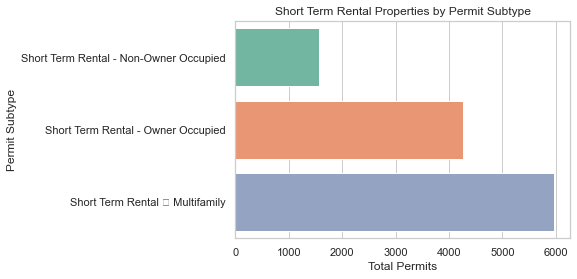

In [116]:
sns.set_theme(style='whitegrid')
pb = sns.barplot(x="total_permits", y="str_permit_subtype", data = str_by_subtype, palette='Set2')
plt.title('Short Term Rental Properties by Permit Subtype')
plt.xlabel('Total Permits')
plt.ylabel('Permit Subtype')
pb.figure.set_size_inches(6, 4);

C:\Users\mews2\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 65533 (\N{REPLACEMENT CHARACTER}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


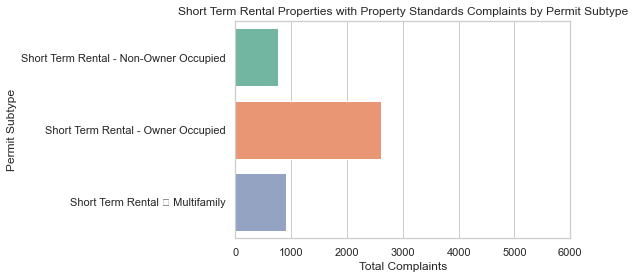

In [120]:
sns.set_theme(style='whitegrid')
pvb = sns.barplot(x='property_complaints', y='str_permit_subtype', data = pv_by_subtype, palette='Set2')
plt.title('Short Term Rental Properties with Property Standards Complaints by Permit Subtype')
plt.xlabel('Total Complaints')
plt.ylabel('Permit Subtype')
pvb.set(xlim=(0, 6000))
pvb.figure.set_size_inches(6, 4);

In [122]:
str_pv_by_violations = str_pv1.groupby(['violations_noted'])['request'].count()
str_pv_by_violations = pd.DataFrame(str_pv_by_violations).reset_index()
str_pv_by_violations.columns = ['violation', 'property_complaints']
str_pv_by_violations = str_pv_by_violations.sort_values('property_complaints', ascending=False)
top_str_pv_by_violations = str_pv_by_violations.head(10)

In [107]:
prop_violations['violations_noted'] = prop_violations['violations_noted'].str.upper()
prop_violations = prop_violations.replace({'EXCESSIVE NOISE/WASTE' : 'EXCESSIVE NOISE / WASTE'})
pv_by_violations = prop_violations.groupby(['violations_noted'])['request'].count()
pv_by_violations = pd.DataFrame(pv_by_violations).reset_index()
pv_by_violations.columns = ['violation', 'property_complaints']
pv_by_violations = pv_by_violations.sort_values('property_complaints', ascending=False)
pv_by_violations.head(10)

,violation,property_complaints
3104,HIGH WEEDS,6446
3337,"OPEN STORAGE, JUNK, TRASH, DEBRIS",6371
3460,PARKING ON GRASS,2804
3606,STRP PERMIT REQUIRED,1677
3613,UNLIC / INOP / ACCUMULATION MTR VEHICLES,1475
2627,EXTERIOR PROP AREA � OPEN STORAGE - ALL,1226
3472,"PARKING ON GRASS,UNLIC / INOP / ACCUMULATION M...",1131
3123,"HIGH WEEDS,OPEN STORAGE, JUNK, TRASH, DEBRIS",1104
3621,VEHICLE IN THE RIGHT OF WAY,932
3372,"OPEN STORAGE, JUNK, TRASH, DEBRIS,PARKING ON G...",832


C:\Users\mews2\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 65533 (\N{REPLACEMENT CHARACTER}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


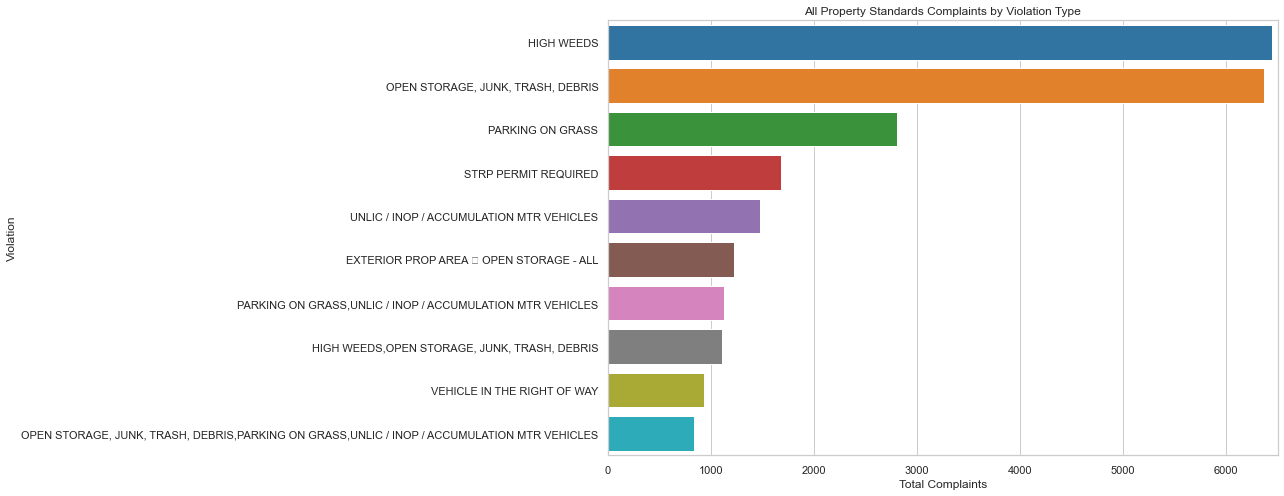

In [137]:
sns.set_theme(style='whitegrid')
svb = sns.barplot(x='property_complaints', y='violation', data = pv_by_violations.head(10), palette='tab10')
plt.title('All Property Standards Complaints by Violation Type')
plt.xlabel('Total Complaints')
plt.ylabel('Violation')
svb.set(xlim=(0, 6500))
svb.figure.set_size_inches(12, 8);

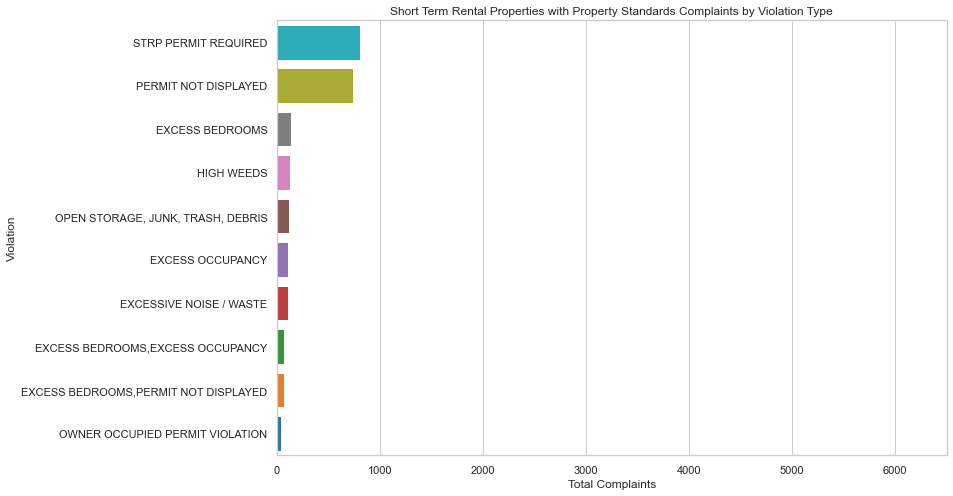

In [138]:
sns.set_theme(style='whitegrid')
avb = sns.barplot(x='property_complaints', y='violation', data = top_str_pv_by_violations, palette='tab10_r')
plt.title('Short Term Rental Properties with Property Standards Complaints by Violation Type')
plt.xlabel('Total Complaints')
plt.ylabel('Violation')
avb.set(xlim=(0, 6500))
avb.figure.set_size_inches(12, 8);

In [147]:
pv_by_zip = str_pv1.groupby(['zip'])['request'].count()
pv_by_zip = pd.DataFrame(pv_by_zip).reset_index()
pv_by_zip.columns = ['str_zipcode', 'property_complaints']
pv_by_zip = pv_by_zip.sort_values('property_complaints', ascending=False)
pv_by_zip

,str_zipcode,property_complaints
14,37206,825
15,37207,503
16,37208,404
11,37203,392
17,37209,332
23,37216,306
20,37212,280
19,37211,215
21,37214,162
12,37204,152


In [149]:
str_by_zip = issued_str.groupby(['zip'])['permit'].count()
str_by_zip = pd.DataFrame(str_by_zip).reset_index()
str_by_zip.columns = ['str_zipcode', 'total_permits']
str_by_zip = str_by_zip.sort_values('total_permits', ascending=False)
str_by_zip

,str_zipcode,total_permits
14,37203,2303
17,37206,1413
19,37208,1068
23,37212,1041
18,37207,959
20,37209,883
27,37216,685
21,37210,525
13,37201,514
15,37204,426


In [154]:
zip_pv_proportions = pd.merge(str_by_zip, pv_by_zip)
zip_pv_proportions['proportion_complaints'] = round((zip_pv_rate['property_complaints']/
                                                     zip_pv_rate['property_complaints'].sum())*100, 1)
zip_pv_proportions['proportion_permits'] = round((zip_pv_rate['total_permits']/
                                                     zip_pv_rate['total_permits'].sum())*100, 1)
zip_pv_proportions = zip_pv_proportions.sort_values('proportion_complaints', ascending=False)
zip_pv_proportions

,str_zipcode,total_permits,property_complaints,proportion_complaints,proportion_permits
1,37206,1413,825,19.3,12.0
4,37207,959,503,11.8,8.2
2,37208,1068,404,9.4,9.1
0,37203,2303,392,9.2,19.6
5,37209,883,332,7.8,7.5
6,37216,685,306,7.1,5.8
3,37212,1041,280,6.5,8.9
11,37211,336,215,5.0,2.9
12,37214,300,162,3.8,2.6
9,37204,426,152,3.6,3.6


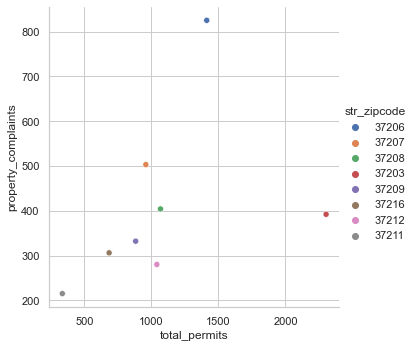

In [156]:
sns.relplot(data=zip_pv_proportions.head(8), x="total_permits", y="property_complaints", hue="str_zipcode");

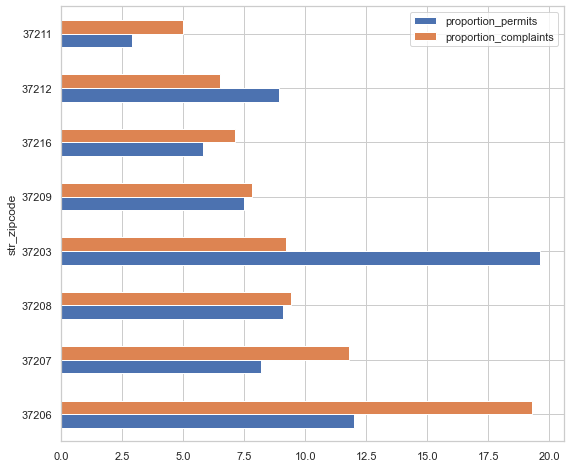

In [160]:
zip_pv_proportions.head(8).plot(x="str_zipcode", y=["proportion_permits", "proportion_complaints"], kind="barh",figsize=(9,8));

### Bonus

#### Question 7
Socrata is used by many cities, states, and federal organizations. Find additional datasets through [Socrata's Open Data Network](http://www.opendatanetwork.com/) and do an analysis comparing them to Nashville or each other.